# Machine learning on autism data

## Importing the required modules

In [3]:
from scipy.io import arff
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import sklearn
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

## Loading the data

The data is arff files, which contain two parts : one with metadata, and one with data. The first 10 columns are  responses to 10 different questions about their life habits. We also have data about the person : gender, ethnicity, jundice when he was young, country, age, whether one parent have a ASD-like trouble ('austim')... We also know if the child is autistic or not ('Class/ASD'). We also have a few information about the person responding the questionnaire (its relation to the child, its use of the app before etc.). 

We have three different data sets (child, adolescent, adult) that I want to merge into a single one in order to have more observations and therefore better predictions. 

In [4]:
# I load the data from the arff file into two files (data and meta) for each data set 
data_child, meta_child =arff.loadarff('Autism-Child-Data.arff')
data_child=pd.DataFrame(data_child)

data_ado, meta_ado =arff.loadarff('Autism-Adolescent-Data.arff')
data_ado=pd.DataFrame(data_ado)

data_adult, meta_adult =arff.loadarff('Autism-Adult-Data.arff')
data_adult=pd.DataFrame(data_adult)

# I store the names of columns in different lists to check whether we have the same variables
names_child=list(data_child.columns.values)
names_ado=list(data_ado.columns.values)
names_adult=list(data_adult.columns.values)

# I assert that the variables are the same
assert names_child==names_ado
assert names_child==names_adult

## Handling missing values

I want to handle missing values by replacing it by their mean. I want to to this before merging the different data sets because I hypothesis that some variables are very different from a child to an adult. Therefore, I search for missing values and handle it before merging the datasets. 

In [5]:
# I want to know where my missing values are.
for name in names_child:
    if data_child[name].isnull().sum()!=0:
        print("There are missing values in the child dataset in the " + name + " column")
    if data_ado[name].isnull().sum()!=0:
        print("There are missing values in the adolescent dataset in the " + name + " column")
    if data_adult[name].isnull().sum()!=0:
        print("There are missing values in the adult dataset in the " + name + " column")

There are missing values in the child dataset in the age column
There are missing values in the adult dataset in the age column


We observe that missing values are only present on age variable in child and adult datasets. I can replace them by the mean of their category (mean age of children, mean age of adults).

In [6]:
# Fill nas with the mean of the column
age_mean_child=data_child.age.mean()
data_child['age']=data_child['age'].fillna(age_mean_child)

age_mean_ado=data_ado.age.mean()
data_ado['age']=data_ado['age'].fillna(age_mean_ado)

age_mean_adult=data_adult.age.mean()
data_adult['age']=data_adult['age'].fillna(age_mean_adult)

for name in names_child:
    assert data_child[name].isnull().sum()==0
    assert data_ado[name].isnull().sum()==0
    assert data_adult[name].isnull().sum()==0

## Merging datasets

I merge the three datasets. We should have always the same number of variables (21) and a number of observations which equals the sum of all observations (292+104+704 = 1100).

In [7]:
data=pd.concat([data_child, data_ado, data_adult])
print(data_child.shape)
print(data_ado.shape)
print(data_adult.shape)
print(data.shape)

names=list(data.columns.values)

(292, 21)
(104, 21)
(704, 21)
(1100, 21)


## Tidying data

We start by turning values into numerical values.

In [8]:
#Turn the numeric strings in real numerical data
numeric=names[0:11]
for name in numeric:
    data[name]=pd.to_numeric(data[name])

data['result']=pd.to_numeric(data['result'])
data['age']=pd.to_numeric(data['age'])

data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1100 entries, 0 to 703
Data columns (total 21 columns):
A1_Score           1100 non-null int64
A2_Score           1100 non-null int64
A3_Score           1100 non-null int64
A4_Score           1100 non-null int64
A5_Score           1100 non-null int64
A6_Score           1100 non-null int64
A7_Score           1100 non-null int64
A8_Score           1100 non-null int64
A9_Score           1100 non-null int64
A10_Score          1100 non-null int64
age                1100 non-null float64
gender             1100 non-null object
ethnicity          1100 non-null object
jundice            1100 non-null object
austim             1100 non-null object
contry_of_res      1100 non-null object
used_app_before    1100 non-null object
result             1100 non-null float64
age_desc           1100 non-null object
relation           1100 non-null object
Class/ASD          1100 non-null object
dtypes: float64(2), int64(10), object(9)
memory usage: 189.1+ 

We turn our binary variables into numerical ones. I chose to recode as it follows:
- for gender, 0 is man and 1 is woman
- for autism, jundice, and used_app_before,  0 is no and 1 is yes

In [9]:
#We turn our binary variables into numerical ones 
data.loc[data['gender'] == b'm', 'gender'] = 0
data.loc[data['gender'] == b'f', 'gender'] = 1

binary=['austim', 'jundice', 'used_app_before']
for name in binary:
    data.loc[data[name] == b'no', name] = 0
    data.loc[data[name] == b'yes', name] = 1

data.loc[data['Class/ASD'] == b'NO', 'Class/ASD'] = 0
data.loc[data['Class/ASD'] == b'YES', 'Class/ASD'] = 1
    
data.head()

,A1_Score,A2_Score,A3_Score,A4_Score,A5_Score,A6_Score,A7_Score,A8_Score,A9_Score,A10_Score,...,gender,ethnicity,jundice,austim,contry_of_res,used_app_before,result,age_desc,relation,Class/ASD
0,1,1,0,0,1,1,0,1,0,0,...,0,b'Others',0,0,b'Jordan',0,5.0,b'4-11 years',b'Parent',0
1,1,1,0,0,1,1,0,1,0,0,...,0,b'Middle Eastern ',0,0,b'Jordan',0,5.0,b'4-11 years',b'Parent',0
2,1,1,0,0,0,1,1,1,0,0,...,0,b'?',0,0,b'Jordan',1,5.0,b'4-11 years',b'?',0
3,0,1,0,0,1,1,0,0,0,1,...,1,b'?',1,0,b'Jordan',0,4.0,b'4-11 years',b'?',0
4,1,1,1,1,1,1,1,1,1,1,...,0,b'Others',1,0,b'United States',0,10.0,b'4-11 years',b'Parent',1


All children have between 4 and 11 years (with the unique function we can check that there is only one value), therefore it is not useful to keep the age_desc variable. We can drop it.

In [10]:
print(data['age_desc'].unique())
data=data.drop('age_desc', axis=1)

[b'4-11 years' b'12-16 years' b'12-15 years' b'18 and more']


## Visualizing the data

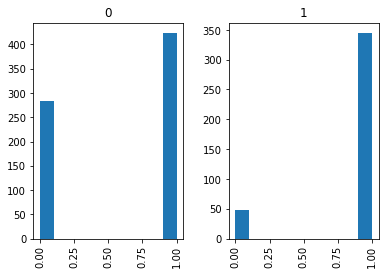

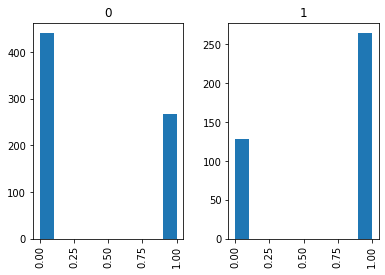

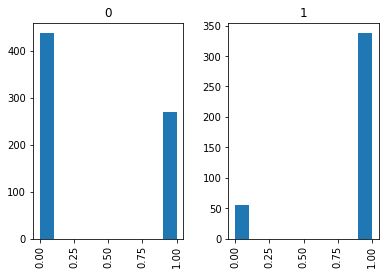

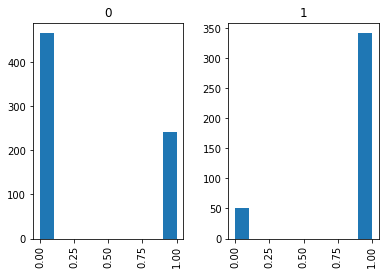

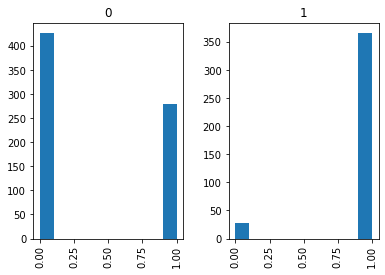

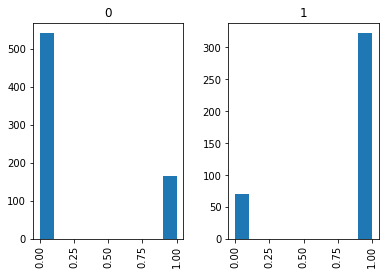

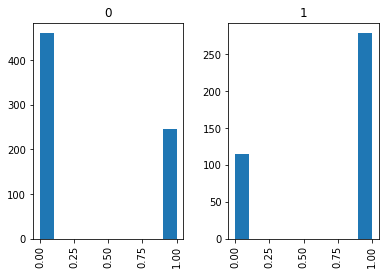

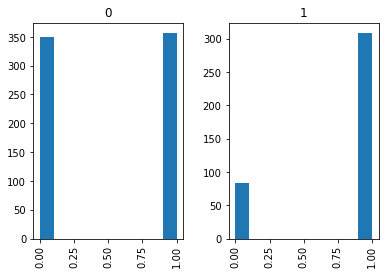

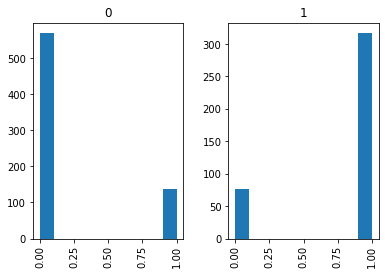

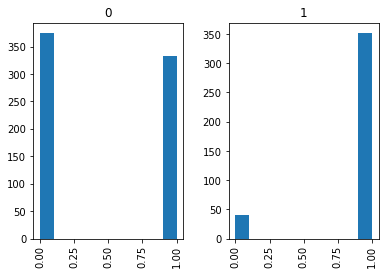

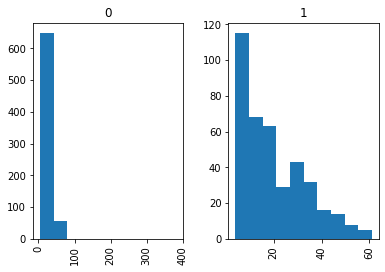

In [11]:
number=1
for name in numeric:
    data.hist(column=name, by='Class/ASD')
    plt.show()
    

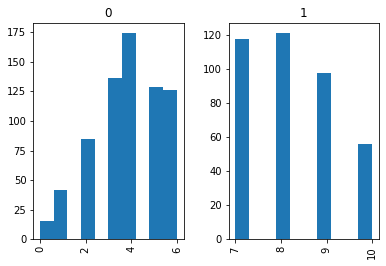

In [12]:
data.hist(column='result', by='Class/ASD', bins=10)
plt.show()

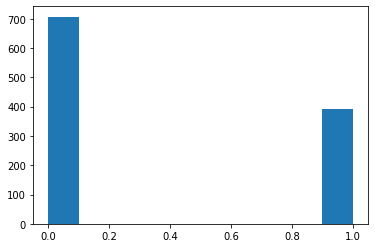

In [13]:
fig, ax = plt.subplots()
ax.hist(data['Class/ASD'])
plt.show()

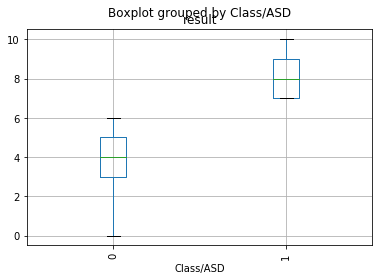

In [26]:
data.boxplot(column='result', by="Class/ASD", rot=90)
plt.show()

## PCA

In [35]:
# Creating the PCA element, transform data
scaler = StandardScaler()
X = scaler.fit_transform(X)
pca = PCA(n_components=3)
principal_components = pca.fit_transform(X)
final = pd.DataFrame(data = principal_components, columns = ['PC1', 'PC2', 'PC3'])
final = final.assign(y=analyse[['Class/ASD']].values)

,PC1,PC2,PC3,y
0,0.491574,-0.492621,-0.759509,0
1,0.491574,-0.492621,-0.759509,0
2,0.589317,-2.528058,-1.182763,0
3,0.459817,-2.271346,1.691022,0
4,-3.660007,-1.168019,-0.310504,1


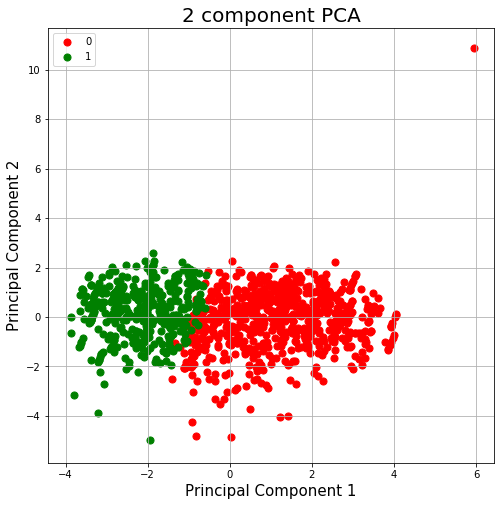

In [20]:
# Plotting PCA 

fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
targets = [0, 1]
colors = ['r', 'g']
for target, color in zip(targets,colors):
    indicesToKeep = final['y'] == target
    ax.scatter(final.loc[indicesToKeep, 'PC1'], final.loc[indicesToKeep, 'PC2'], c = color, s = 50)
ax.legend(targets)
ax.grid()

plt.show()

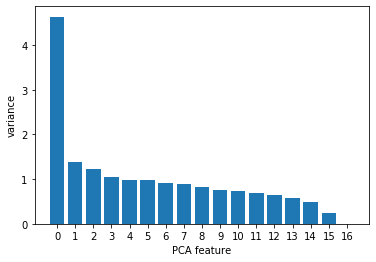

In [21]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
import matplotlib.pyplot as plt

# Create scaler: scaler
scaler = StandardScaler()

# Create a PCA instance: pca
pca = PCA()

# Create pipeline: pipeline
pipeline = make_pipeline(scaler, pca)

# Fit the pipeline to 'samples'
pipeline.fit(analyse)

# Plot the explained variances
features = range(pca.n_components_)
plt.bar(features, pca.explained_variance_)
plt.xlabel('PCA feature')
plt.ylabel('variance')
plt.xticks(features)
plt.show()

In [22]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Scale the data
scaler = StandardScaler()
scaled = scaler.fit_transform(analyse)

# Apply PCA
pca = PCA()
pca.fit(scaled)

print(pca.explained_variance_ratio_)
print(pca.explained_variance_ratio_.cumsum())

[2.72440164e-01 8.15825201e-02 7.17966796e-02 6.14500738e-02
 5.81594429e-02 5.74332750e-02 5.39353984e-02 5.19196767e-02
 4.82691418e-02 4.42758743e-02 4.32775232e-02 4.03442527e-02
 3.82539032e-02 3.43911108e-02 2.81309196e-02 1.43400443e-02
 5.37947572e-33]
[0.27244016 0.35402268 0.42581936 0.48726944 0.54542888 0.60286216
 0.65679755 0.70871723 0.75698637 0.80126225 0.84453977 0.88488402
 0.92313793 0.95752904 0.98565996 1.         1.        ]


## K-Nearest Neighbors

To simplify the first analysis, I drop the country of residence, the ethnicity and the relation to the person who is answering. 

In [27]:
analyse=data.drop('ethnicity', axis=1)
analyse=analyse.drop('contry_of_res', axis=1)
analyse=analyse.drop('relation', axis=1)

In [31]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split

# Create arrays for the features and the response variable
y = list(analyse['Class/ASD'].values)
X = analyse.drop('Class/ASD', axis=1).values

# Create a k-NN classifier with 6 neighbors
knn = KNeighborsClassifier(n_neighbors=3)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=42, stratify=y)
# Fit the classifier to the data
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)
print(knn.score(X_test, y_test))

0.9696969696969697


In [32]:
from sklearn.metrics import confusion_matrix


conf_matrix = confusion_matrix(y_test, y_pred)


## Linear Regression

In [18]:
from sklearn.linear_model import LinearRegression
reg = LinearRegression()
reg.fit(X_train, y_train)
y_pred=reg.predict(X_test)
print(reg.score(X_test, y_test))

0.6784656826900608
